In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../utils")
sys.path.append("../phantoms")
sys.path.append("../projections")
from src.algs import *
from src.projections import *
from src.phantoms import *


<h4>Semilunar phantom creation</h4>

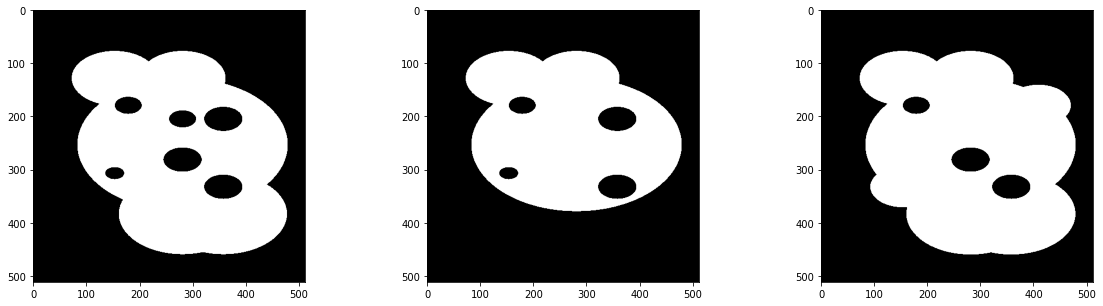

In [2]:
phantoms = create_phantoms("clouds", 512, n=3, overlap=True,
                                seed=0, img_name=None)
fig, ax = plt.subplots(1, len(phantoms), figsize=(20,5))
for i in range(len(phantoms)):
    ax[i].imshow(phantoms[i], cmap="Greys_r")

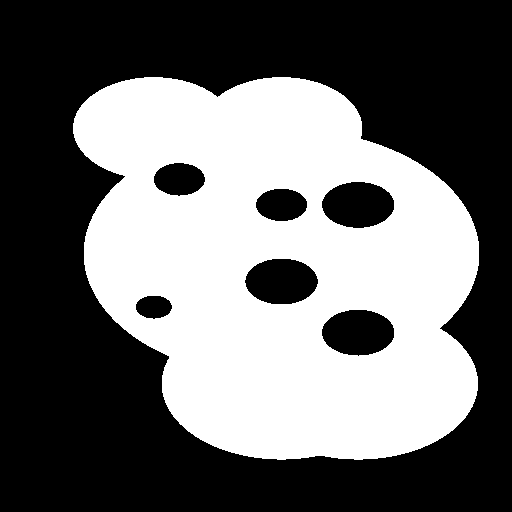

In [3]:
Image.fromarray(phantoms[0])

<h4>Measurement parameters for DART</h4>

In [4]:
# ,easurement parameters
n_projections = 10
n_detectors = 512
det_spacing = 1
noise_factor = None
angles = np.linspace(0, np.pi, n_projections)
# dart paramenters
dart_iters = 10
p = 0.9
rec_alg = 'SART_CUDA'
rec_iters = 1000
# compared algs iters
comp_iters = dart_iters * rec_iters

# open phantom
img = phantoms[0]
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
# make measurements
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)

# instanciate DART
dart = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
        proj_geom=proj_geom, projector_id=projector_id,
        sinogram=sinogram)

<h4>Initial reconstruction</h4>

Mean absolute pixel error: 3.3923466205596924


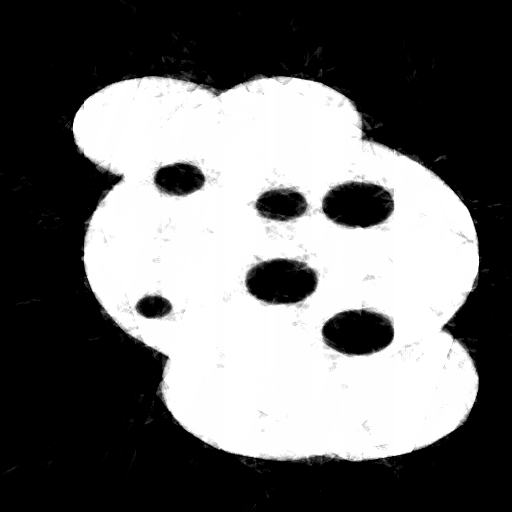

In [5]:
# fix gray levels and thresholds
dart.gray_levels = np.unique(img).astype(np.float16)
dart.thresholds = dart.update_gray_thresholds()
# run the algorithm for 0 iterations
init_rec = dart.run(iters=0, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - init_rec).mean()}")
Image.fromarray(init_rec.astype(np.uint8))

<br/>
<h4>Segmentation step</h4>

Initial gray levels: [0, 127.5, 255]
Gray levels in segmented image: [  0 255]
Mean absolute pixel error: 0.22001266479492188
Segmented image:


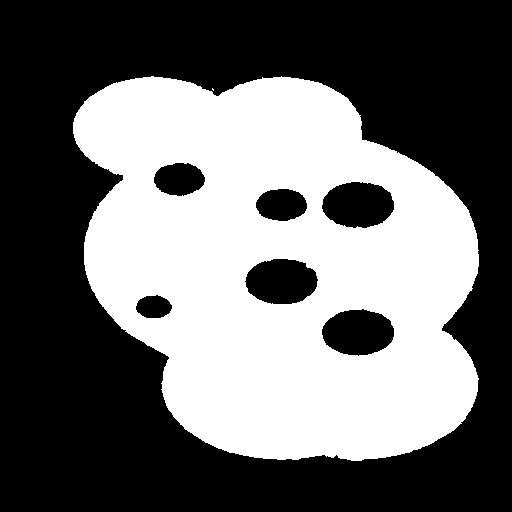

In [6]:
# # defining new gray levels
# gray_levels = [40, 60, 200]
# dart.gray_levels = gray_levels
# update DART thresholds
dart.thresholds = dart.update_gray_thresholds()
# Segmentation step
segmented_img = dart.segment(init_rec)
print(f"Initial gray levels: {dart.thresholds}")
print(f"Gray levels in segmented image: {np.unique(segmented_img)}")
print(f"Mean absolute pixel error: {np.abs(img - segmented_img).mean()}")
print("Segmented image:")
Image.fromarray(segmented_img)

<br/>
<h4>Boundary pixels</h4>

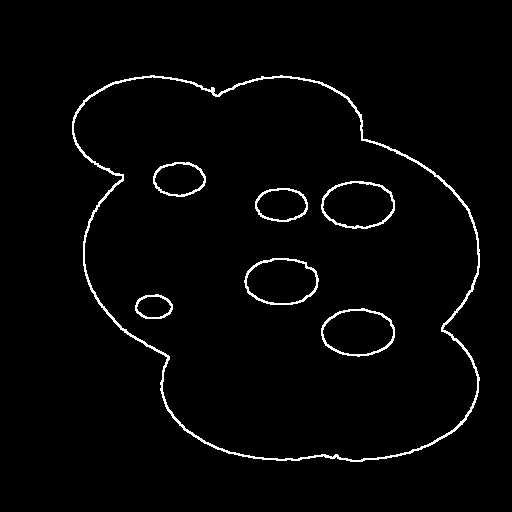

In [7]:
boundaries = dart.boundary_pixels(segmented_img)
Image.fromarray(boundaries)

<br/>
<h4>Free pixels</h4>

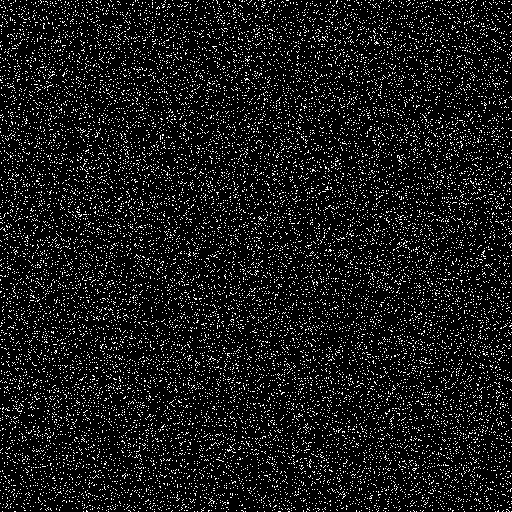

In [8]:
free_pixels = dart.free_pixels()
Image.fromarray(free_pixels)

<br/>
<h4>Total free pixels</h4>

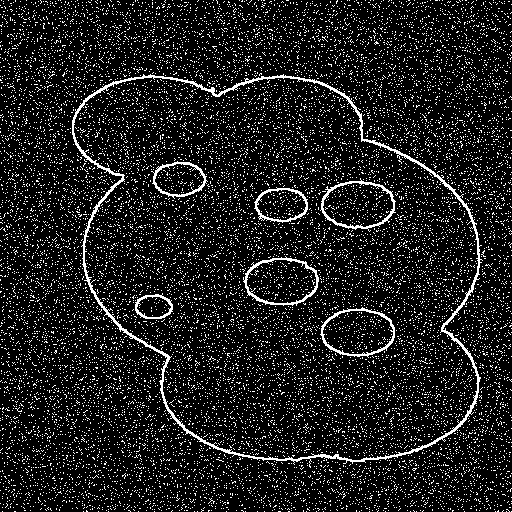

In [9]:
all_free_pixels = np.logical_or(boundaries,free_pixels)
Image.fromarray(all_free_pixels)

<h4>Reconstruction of free pixels</h4>

Mean absolute pixel error: 1.0558620691299438


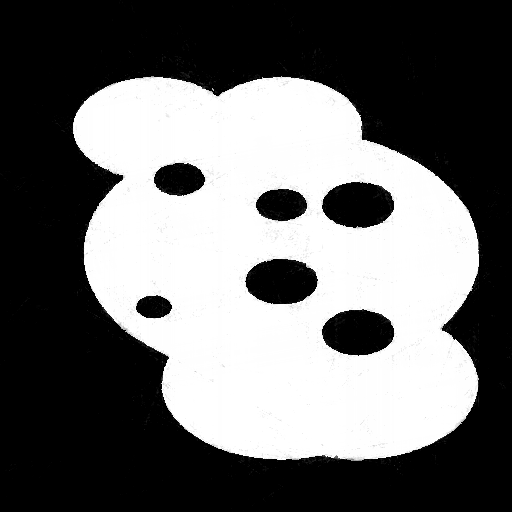

In [10]:
new_phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
new_projector_id, new_sino_id, _ = project_from_2D(phantom_id=new_phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

# fix gray levels and thresholds
_, first_rec = SART(vol_geom,segmented_img,new_projector_id,new_sino_id,
                    iters=1000, use_gpu=True)

print(f"Mean absolute pixel error: {np.abs(img - first_rec).mean()}")
Image.fromarray(first_rec.astype(np.uint8))

<br>
<h4>
Running full DART
</h4>

Mean absolute pixel error: 0.652068555355072


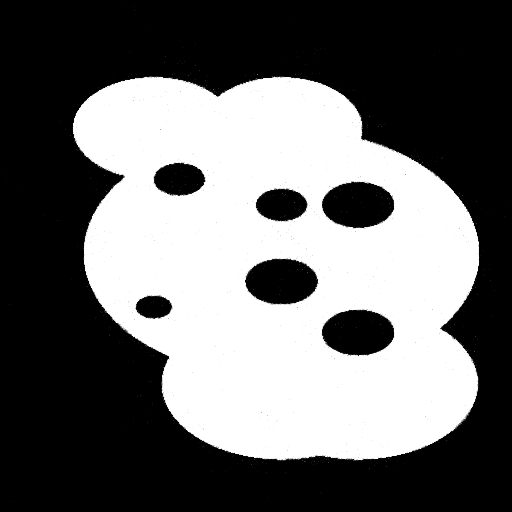

In [11]:
# fix gray levels and thresholds
dart.gray_levels = np.unique(img).astype(np.float16)
dart.thresholds = dart.update_gray_thresholds()
# run the algorithm
full_rec = dart.run(iters=25, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - full_rec).mean()}")
Image.fromarray(full_rec.astype(np.uint8))

Mean absolute pixel error: 0.001983642578125


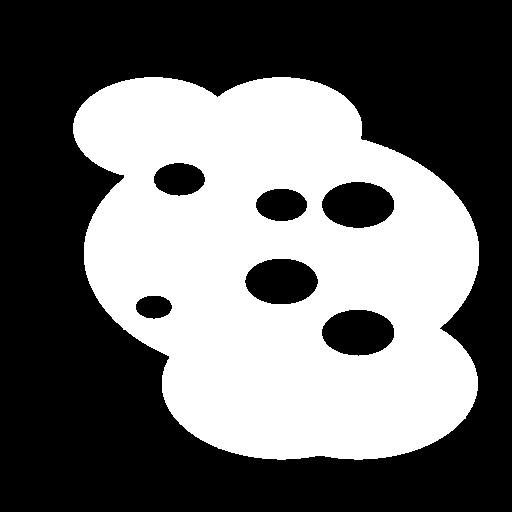

In [12]:
print(f"Mean absolute pixel error: {np.abs(img - Image.fromarray(dart.segment(full_rec))).mean()}")
Image.fromarray(dart.segment(full_rec))

<h4>SART comparison</h4>

In [13]:
_, sart_res = SART(vol_geom,0,projector_id,sino_id,
                    iters=comp_iters, use_gpu=True)

Mean absolute pixel error: 1.13987135887146


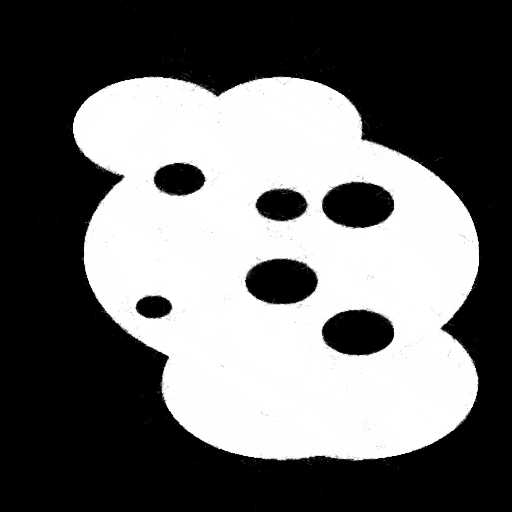

In [14]:
print(f"Mean absolute pixel error: {np.abs(img - sart_res).mean()}")
Image.fromarray(sart_res.astype(np.uint8))

Mean absolute pixel error: 0.02838134765625


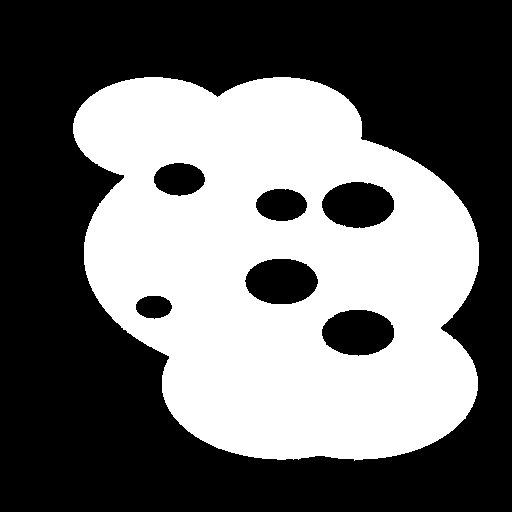

In [15]:
print(f"Mean absolute pixel error: {np.abs(img - Image.fromarray(dart.segment(sart_res))).mean()}")
Image.fromarray(dart.segment(sart_res))

AxesSubplot(0.125,0.536818;0.227941x0.343182)
AxesSubplot(0.398529,0.536818;0.227941x0.343182)
AxesSubplot(0.672059,0.536818;0.227941x0.343182)
AxesSubplot(0.125,0.125;0.227941x0.343182)
AxesSubplot(0.398529,0.125;0.227941x0.343182)
AxesSubplot(0.672059,0.125;0.227941x0.343182)


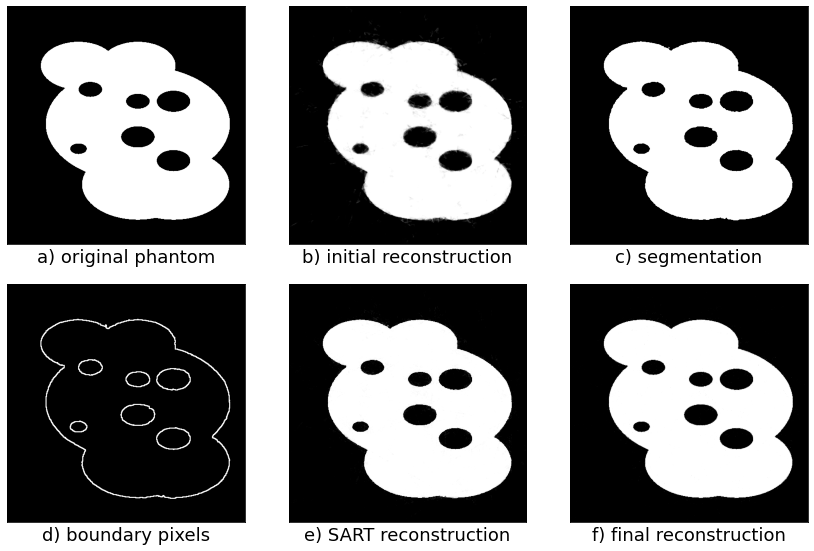

In [24]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

ax[0,0].imshow(img, cmap="Greys_r")
ax[0,0].set_xlabel("a) original phantom")
ax[0,1].imshow(init_rec, cmap="Greys_r")
ax[0,1].set_xlabel("b) initial reconstruction")
ax[0,2].imshow(segmented_img, cmap="Greys_r")
ax[0,2].set_xlabel("c) segmentation")
ax[1,0].imshow(boundaries, cmap="Greys_r")
ax[1,0].set_xlabel("d) boundary pixels")
ax[1,1].imshow(first_rec, cmap="Greys_r")
ax[1,1].set_xlabel("e) SART reconstruction")
ax[1,2].imshow(full_rec, cmap="Greys_r")
ax[1,2].set_xlabel("f) final reconstruction")

for x in ax:
    for y in x:
        print(y)
        y.tick_params(left = False, bottom = False)
        y.set_xticks([])
        y.set_yticks([])
plt.tight_layout()
plt.show()
